<a href="https://colab.research.google.com/github/ATOMScience-org/AMPL/blob/master/atomsci/ddm/examples/tutorials/AMPL_FNL_Wrshp2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FNL AMPL Workshop2-3: Merge datasets, collapse duplicates, final curation steps

> In this notebook we will be analyzing Histamine Receptor H1 (HRH1) target binding assay measurement datasets  from ChEMBL, DTC and ExCAPE-DB to harmonize and create ML-ready dataset<br>
ChEMBL: https://www.ebi.ac.uk/chembl/<br>
DTC: https://drugtargetcommons.fimm.fi/<br>
ExCAPE-DB: https://solr.ideaconsult.net/search/excape/ <br>
NCBI Gene information: https://www.ncbi.nlm.nih.gov/gene?Db=gene&Cmd=DetailsSearch&Term=3269


In [1]:
from IPython.display import Image
Image(url='https://raw.githubusercontent.com/ATOMScience-org/AMPL/master/atomsci/ddm/examples/tutorials/Img/AMPL_curation.png?raw=true')

This is a continuation of AMPL Workshop2-2 notebook, https://github.com/ATOMScience-org/AMPL/blob/master/atomsci/ddm/examples/tutorials/AMPL_FNL_Wrshp2_2.ipynb, please review this notebook before you work on this one.  

# AMPL Installation


In [ ]:
! pip install rdkit-pypi
! pip install deepchem

import deepchem
# print(deepchem.__version__)
! pip install umap
! pip install -U --ignore-installed numba
! pip install umap-learn
! pip install molvs
! pip install bravado

In [ ]:
import deepchem as dc

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ATOMScience-org/AMPL/master/atomsci/ddm/examples/tutorials/config/install_AMPL_GPU_test.sh >& /dev/null

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

# Load packages

In [12]:
%matplotlib inline
# manipulate data
import pandas as pd

# plot data
import numpy as np
import matplotlib.pyplot as plt

# curate data
from atomsci.ddm.utils import struct_utils
from atomsci.ddm.utils import curate_data
from atomsci.ddm.pipeline import dist_metrics

# Chemistry functions
from rdkit import Chem

# visualize data
import seaborn as sns
import matplotlib_venn as mpv
from scipy.stats import pearsonr

# set pandas options
pd.set_option('display.max_columns',(90))
pd.set_option('display.max_rows',(20))


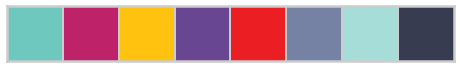

In [13]:
# set up visualization parameters
sns.set_context("poster")
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [10,10]

colors = [
    "#6EC8BE",
    "#BE2369",
    "#FFC30F",
    "#694691",
    "#EB1E23",
    "#7682A4",
    "#A7DDD8",
    "#373C50",
]
# Set your custom color palette
pal=sns.color_palette(colors)
sns.set_palette(pal)
sns.palplot(pal)

# Load Data

In [14]:
! wget https://raw.githubusercontent.com/ATOMScience-org/AMPL/master/atomsci/ddm/examples/tutorials/datasets/HRH1_ChEMBL_SMILES.csv >& /dev/null
! wget https://raw.githubusercontent.com/ATOMScience-org/AMPL/master/atomsci/ddm/examples/tutorials/datasets/HRH1_DTC_SMILES.csv >& /dev/null
! wget https://raw.githubusercontent.com/ATOMScience-org/AMPL/master/atomsci/ddm/examples/tutorials/datasets/HRH1_Excape_SMILES.csv >& /dev/null


In [15]:
chembl = pd.read_csv("HRH1_ChEMBL_SMILES.csv", index_col=0)
dtc = pd.read_csv("HRH1_DTC_SMILES.csv", index_col=0)
excape = pd.read_csv("HRH1_Excape_SMILES.csv", index_col=0)

# Data curation, merging and final dataset EDA
# Explore ChEMBL data

In [16]:
print('ChEMBL shape:', chembl.shape)
print('ChEMBL NA standard values:', chembl[chembl.Standard_Value.isna()].shape)
print('ChEMBL NA pValues:', chembl[chembl.pChEMBL_Value.isna()].shape)

ChEMBL shape: (3844, 47)
ChEMBL NA standard values: (1695, 47)
ChEMBL NA pValues: (2099, 47)


## Check for any zero values before log10 transformation 

In [17]:
(chembl.Standard_Value_nM == 0.0).sum()

2

In [18]:
chembl.shape

(3844, 47)

In [19]:
chembl.drop(chembl[chembl.Standard_Value_nM == 0.0].index, inplace=True)
print(chembl.shape)

(3842, 47)


In [20]:
# rescue NA pChemblValues
chembl['pChEMBL_Value_nM'] = -np.log10(chembl.Standard_Value_nM/1000000000)
chembl[chembl.pChEMBL_Value_nM.isna()].shape

(1695, 48)

In [21]:
chembl.Standard_Type.value_counts()

Ki      2516
IC50    1249
EC50      77
Name: Standard_Type, dtype: int64

In [22]:
# select pIC50 values
vals = ['EC50', 'IC50']
print(chembl.shape)
chembl=chembl[chembl.Standard_Type.isin(vals)]
print(chembl.shape)

(3842, 48)
(1326, 48)


In [23]:
# How many NAs
print(chembl[chembl.pChEMBL_Value_nM.isna()].shape)
print(chembl[chembl.base_rdkit_smiles.isna()].shape)

(828, 48)
(0, 48)


In [24]:
# drop NA pIC50's & smiles; 
# axis = 0 or 'index' (rows)
# subset will the be the list of columns to include for the drop
chembl=chembl.dropna(axis=0, subset = ['pChEMBL_Value_nM','base_rdkit_smiles'])
print(chembl.shape)

(498, 48)


In [25]:
# look for weird punctuation, if any
chembl.Standard_Relation.unique()

array(["'='", "'>'", "'<'", "'~'"], dtype=object)

In [26]:
# flip arrows and fix punctuation for relation column to reflect pValues not normal values
chembl['pRelation'] = chembl.Standard_Relation
chembl['pRelation'] = np.where(chembl.Standard_Relation == "'<'", ">", chembl.pRelation)
chembl['pRelation'] = np.where(chembl.Standard_Relation == "'>'", "<", chembl.pRelation)
chembl['pRelation'] = np.where(chembl.Standard_Relation == "'='", "=", chembl.pRelation)
chembl['pRelation'] = np.where(chembl.Standard_Relation == "'~'", "=", chembl.pRelation)

# Example 'IC50' --> 'pIC50'
chembl['pStandard_Type']='p'+chembl.Standard_Type

chembl[['Standard_Relation', 'pRelation']].head()

,Standard_Relation,pRelation
28,'=',=
30,'=',=
31,'>',<
32,'=',=
33,'=',=


In [27]:
display(chembl[['Standard_Type', 'Standard_Relation', 'Standard_Value_nM']].head())
chembl[['pStandard_Type', 'pRelation', 'pChEMBL_Value_nM']].head()

,Standard_Type,Standard_Relation,Standard_Value_nM
28,IC50,'=',6.36
30,IC50,'=',6.55
31,EC50,'>',10000.00
32,IC50,'=',6.39
33,IC50,'=',5.04


,pStandard_Type,pRelation,pChEMBL_Value_nM
28,pIC50,=,8.196543
30,pIC50,=,8.183759
31,pEC50,<,5.000000
32,pIC50,=,8.194499
33,pIC50,=,8.297569


In [28]:
# check for empty values in other important columns
chembl[chembl.Molecule_ChEMBL_ID.isna()]

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM,base_rdkit_smiles,pChEMBL_Value_nM,pRelation,pStandard_Type


### Curate individual data frames
- remove all the bad `base_rdkit_smiles` duplicates `pChEMBL_Value_nm` based on `max_stddev` and tolerance (`tol`); the ones with too much variability between measurements

In [29]:
# testing (uncomment only if you want to explore the changes)
# df_lt = chembl[chembl['pRelation'] == "<"]
# df_lt.loc[df_lt.duplicated(subset=['Molecule_ChEMBL_ID']), :]

In [30]:
chembl_rm = curate_data.average_and_remove_duplicates(column='pChEMBL_Value_nM', 
                                                      max_stdev=2, 
                                                      tolerance=100,
                                                      list_bad_duplicates='Yes', 
                                                      rm_duplicate_only=True, 
                                                      data=chembl, 
                                                      compound_id='Molecule_ChEMBL_ID', 
                                                      smiles_col='base_rdkit_smiles')

Bad duplicates removed from dataset
Dataframe size (482, 54)
List of 'bad' duplicates removed
    Molecule_ChEMBL_ID  pChEMBL_Value_nM  VALUE_NUM_mean   Perc_Var  \
45          CHEMBL1172          8.735182        6.581986  32.713481   
66          CHEMBL1172          4.795880        6.581986  27.136273   
286         CHEMBL1172          4.795880        6.581986  27.136273   
346         CHEMBL1172          8.001000        6.581986  21.559064   
116       CHEMBL330366          5.000000        6.761439  26.051248   
154       CHEMBL330366          8.522879        6.761439  26.051248   
128       CHEMBL411691          8.349692        6.907833  20.872816   
16        CHEMBL537027          5.465974        6.907833  20.872816   
261          CHEMBL564          8.464073        7.037037  20.278944   
374          CHEMBL564          5.610000        7.037037  20.278944   
222          CHEMBL908          9.000000        7.530001  19.521898   
265          CHEMBL908          6.060002        7.5300

In [31]:
# testing (uncomment only if you want to explore the changes)
# df_rm_lt = chembl_rm[chembl_rm['pRelation'] == "<"]
# df_rm_lt.loc[df_rm_lt.duplicated(subset=['Molecule_ChEMBL_ID']), :]

In [32]:
# IC50 of 100nM for threshold --> pIC50
thresh=-np.log10(100/1000000000) 
thresh

7.0

## `aggregate_assay_data` 
*Map RDKit SMILES strings in assay_df to base structures, then compute an Maximum Liklihood Estimate (MLE) estimate of the mean value over replicate measurements for the same SMILES strings, taking censoring into account. Generate an aggregated result table with one value for each unique base SMILES string, to be used in an ML-ready dataset.*


In [33]:
# chembl_rm.head(3)

In [34]:
print(chembl_rm.shape)
chembl_cur = curate_data.aggregate_assay_data(chembl_rm, value_col = 'pChEMBL_Value_nM', 
                                              output_value_col = 'pXC50',
                                              id_col = 'Molecule_ChEMBL_ID', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'pRelation',
                                              active_thresh=thresh)
print(chembl_cur.shape)
chembl_cur.head()

(482, 54)
0 entries in input table are missing SMILES strings
379 unique SMILES strings are reduced to 379 unique base SMILES strings
(379, 5)


,compound_id,base_rdkit_smiles,relation,pXC50,active
0,CHEMBL1411979,CN(C)CCN(Cc1cccs1)c1ccccn1,,7.795880,1
1,CHEMBL134423,Fc1ccc([Si]2(c3ccc(F)cc3)CCC(N3CCN(c4ccccc4)CC...,<,6.000000,0
2,CHEMBL716,OCCOCCN1CCN(C2=Nc3ccccc3Sc3ccccc32)CC1,,7.402305,1
3,CHEMBL1783962,CN1CCc2c(c3cc(C(F)(F)F)ccc3n2CCc2cccnc2)C1,<,5.000000,0
4,CHEMBL485543,Cc1nc2cccc(C(F)(F)F)c2c(=O)n1-c1ccc(OC2CCN(C3C...,<,5.000000,0


In [35]:
# cens_lt_list = ['CHEMBL214312', 'CHEMBL134423','CHEMBL468176','CHEMBL4563408']
# chembl_cur[chembl_cur['compound_id'].isin(cens_lt_list)]

In [36]:
chembl_cur.to_csv("HRH1_ChEMBL_cur.csv")

# DTC Curation


<div class="alert alert-success">
    <b>Exercise-1: DTC Curation </b>:
    <li>  Make sure you have an unique IDs in column `compound_id`. If not copy `standard_inchi_key` values to `compound_id` column 
    <li>  check for `isna` on `compound_id`
    <li>  cound the # of isna rows
    <li>  create/overwrite dtc df to contain only ['EC50', 'IC50', 'PIC50'] values
    <li>  Create 'pRelation' column and add pRelation values  
    <li> Remove bad duplicates and average values within cutoffs (ex., std = 2). Call `curate_data.average_and_remove_duplicates` function to accomplish this task
    <li> aggregate duplicates. Call `curate_data.aggregate_assay_data` to accomplish this task 
</div> 

<div class="alert alert-info">
    <b> Solution for Exercise-1: Try on your own. If you want to see the solution, click the following cell </b>
    
</div>

<details><summary>Click here for the solution</summary>

```python
# get unique compound IDs
dtc['compound_id'] = np.where(dtc.compound_id.isna(),    
                              dtc.standard_inchi_key, 
                              dtc.compound_id)

# check for isna
dtc[dtc.compound_id.isna()]
# count # of isna rows
dtc['compound_id'].isna().sum()

# select pIC50 values
vals = ['EC50', 'IC50', 'PIC50']
print(dtc.shape)
dtc=dtc[dtc.standard_type.isin(vals)]
print(dtc.shape)

# flip arrows for relation column to reflect pValues not normal values
dtc['pRelation'] = dtc.standard_relation
dtc['pRelation'] = np.where(dtc.standard_relation == "<", ">", dtc.pRelation)
dtc['pRelation'] = np.where(dtc.standard_relation == ">", "<", dtc.pRelation)
dtc['pRelation'] = np.where(dtc.standard_relation == "=", "=", dtc.pRelation)
dtc['pRelation'] = np.where(dtc.standard_relation == "~", "=", dtc.pRelation)

print(dtc.pRelation.unique())

# drop NAs on selected columns, 'pDTC_Values', 'base_rdkit_smiles'
dtc=dtc.dropna(axis=0, subset = ['pDTC_Value','base_rdkit_smiles'])
print(dtc.shape)

# remove bad duplicates and average duplicates
dtc_rm = curate_data.average_and_remove_duplicates(column='pDTC_Value', 
                                                   max_stdev=2, 
                                                   tolerance=100,
                                                   list_bad_duplicates='Yes', 
                                                   rm_duplicate_only=True, 
                                                   data=dtc, 
                                                   compound_id='compound_id', 
                                                   smiles_col='base_rdkit_smiles')

# aggregate duplicates
dtc_cur = curate_data.aggregate_assay_data(dtc_rm, value_col = 'pDTC_Value', 
                                              output_value_col = 'pXC50',
                                              id_col = 'compound_id', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'pRelation',
                                              active_thresh=thresh)
# save the curated df to a file 
dtc_cur.to_csv("HRH1_DTC_cur.csv")

# print shpae and first 5 lines of the df
print(dtc_cur.shape)
print(dtc_cur.relation.unique())
dtc_cur.head() 
    
```

</details>

In [37]:
#***********************************************************
# solution cell code chunk copied here to run the notebook *
#***********************************************************



# get unique compound IDs
dtc['compound_id'] = np.where(dtc.compound_id.isna(),    
                              dtc.standard_inchi_key, 
                              dtc.compound_id)

# check for isna
dtc[dtc.compound_id.isna()]
# count # of isna rows
dtc['compound_id'].isna().sum()

# select pIC50 values
vals = ['EC50', 'IC50', 'PIC50']
print(dtc.shape)
dtc=dtc[dtc.standard_type.isin(vals)]
print(dtc.shape)

# flip arrows for relation column to reflect pValues not normal values
dtc['pRelation'] = dtc.standard_relation
dtc['pRelation'] = np.where(dtc.standard_relation == "<", ">", dtc.pRelation)
dtc['pRelation'] = np.where(dtc.standard_relation == ">", "<", dtc.pRelation)
dtc['pRelation'] = np.where(dtc.standard_relation == "=", "=", dtc.pRelation)
dtc['pRelation'] = np.where(dtc.standard_relation == "~", "=", dtc.pRelation)

print(dtc.pRelation.unique())

# drop NAs on selected columns, 'pDTC_Values', 'base_rdkit_smiles'
dtc=dtc.dropna(axis=0, subset = ['pDTC_Value','base_rdkit_smiles'])
print(dtc.shape)

# remove bad duplicates and average duplicates
dtc_rm = curate_data.average_and_remove_duplicates(column='pDTC_Value', 
                                                   max_stdev=2, 
                                                   tolerance=100,
                                                   list_bad_duplicates='Yes', 
                                                   rm_duplicate_only=True, 
                                                   data=dtc, 
                                                   compound_id='compound_id', 
                                                   smiles_col='base_rdkit_smiles')

# aggregate duplicates
dtc_cur = curate_data.aggregate_assay_data(dtc_rm, value_col = 'pDTC_Value', 
                                              output_value_col = 'pXC50',
                                              id_col = 'compound_id', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'pRelation',
                                              active_thresh=thresh)
# save the curated df to a file 
dtc_cur.to_csv("HRH1_DTC_cur.csv")

# print shpae and first 5 lines of the df
print(dtc_cur.shape)
print(dtc_cur.relation.unique())
dtc_cur.head() 

(3822, 36)
(1248, 36)
[nan '=' '<' '>']
(447, 37)
Bad duplicates removed from dataset
Dataframe size (434, 41)
List of 'bad' duplicates removed
      compound_id  pDTC_Value  VALUE_NUM_mean   Perc_Var  VALUE_NUM_std
135    CHEMBL1172    4.795880        6.398375  25.045340       2.266270
136    CHEMBL1172    8.000869        6.398375  25.045340       2.266270
368  CHEMBL330366    8.522879        6.761439  26.051248       2.491051
369  CHEMBL330366    5.000000        6.761439  26.051248       2.491051
428  CHEMBL411691    8.349692        6.907833  20.872816       2.039097
315  CHEMBL537027    5.465974        6.907833  20.872816       2.039097
420     CHEMBL564    5.610000        7.036721  20.275366       2.017688
421     CHEMBL564    8.463442        7.036721  20.275366       2.017688
356     CHEMBL908    9.000000        7.530001  19.521898       2.078893
357     CHEMBL908    6.060002        7.530001  19.521898       2.078893
138     CHEMBL998    2.823909        5.377021  47.481906       2

,compound_id,base_rdkit_smiles,relation,pXC50,active
0,CHEMBL1411979,CN(C)CCN(Cc1cccs1)c1ccccn1,,7.795880,1
1,CHEMBL514217,CN(CCN1CCCCC1)C(=O)C1CCC2(CC1)OC(=O)c1ccccc12,<,5.000000,0
2,CHEMBL158352,NCCCCCCCCCCCc1cnc[nH]1,,6.599998,0
3,CHEMBL134423,Fc1ccc([Si]2(c3ccc(F)cc3)CCC(N3CCN(c4ccccc4)CC...,<,6.000000,0
4,CHEMBL716,OCCOCCN1CCN(C2=Nc3ccccc3Sc3ccccc32)CC1,,7.402305,1


# Excape Curation

<div class="alert alert-success">
    <b>Exercise-2: Excape Curation </b>:
    <li>  Note each databases have different meta data columns. Notice that Excape-DB dataset doesnt have any relation column. So, let us create one with all empty string
    <li> dropna rows on ['pXC50', 'base_rdkit_smiles] columns
    <li> Remove bad duplicates and average values within cutoffs (ex., std = 2). Call `curate_data.average_and_remove_duplicates` function to accomplish this task
    <li> aggregate duplicates. Call `curate_data.aggregate_assay_data` to accomplish this task 
</div> 

<div class="alert alert-info">
    <b> Solution for Exercise-1: Try on your own. If you want to see the solution, click the following cell </b>
    
</div>

<details><summary>Click here for the solution</summary>

```python 
excape.head(3)
    
# check for NA in `Original_Entry_ID` column    
excape[excape.Original_Entry_ID.isna()]

# excape: has no relation col, so create one with all ''
excape['pRelation']=''
print(excape.shape)
print(excape.pRelation.unique())
excape=excape.dropna(axis=0, subset = ['pXC50','base_rdkit_smiles'])
print(excape.shape)

# remove bad duplicates
excape_rm = curate_data.average_and_remove_duplicates(column='pXC50', 
                                                      max_stdev=2, 
                                                      tolerance=100,
                                                      list_bad_duplicates='Yes', 
                                                      rm_duplicate_only=True, 
                                                      data=excape, 
                                                      compound_id='Original_Entry_ID', 
                                                      smiles_col='base_rdkit_smiles')

# aggregate duplicates
excape_cur = curate_data.aggregate_assay_data(excape_rm, 
                                              value_col = 'pXC50', 
                                              output_value_col = 'pXC50',
                                              id_col = 'Original_Entry_ID', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'pRelation',
                                              active_thresh=thresh)
excape_cur.to_csv("HRH1_Excape_cur.csv")
print(excape_cur.shape)
print(excape_cur.relation.unique())
excape_cur.head()    

    
    
    
```

</details>

In [38]:
#***********************************************************
# solution cell code chunk copied here to run the notebook *
#***********************************************************  


excape.head(3)

# check for NA in `Original_Entry_ID` column    
excape[excape.Original_Entry_ID.isna()]

# excape: has no relation col, so create one with all ''
excape['pRelation']=''
print(excape.shape)
print(excape.pRelation.unique())
excape=excape.dropna(axis=0, subset = ['pXC50','base_rdkit_smiles'])
print(excape.shape)

# remove bad duplicates
excape_rm = curate_data.average_and_remove_duplicates(column='pXC50', 
                                                      max_stdev=2, 
                                                      tolerance=100,
                                                      list_bad_duplicates='Yes', 
                                                      rm_duplicate_only=True, 
                                                      data=excape, 
                                                      compound_id='Original_Entry_ID', 
                                                      smiles_col='base_rdkit_smiles')

# aggregate duplicates
excape_cur = curate_data.aggregate_assay_data(excape_rm, 
                                              value_col = 'pXC50', 
                                              output_value_col = 'pXC50',
                                              id_col = 'Original_Entry_ID', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'pRelation',
                                              active_thresh=thresh)
excape_cur.to_csv("HRH1_Excape_cur.csv")
print(excape_cur.shape)
print(excape_cur.relation.unique())
excape_cur.head()    

(1283, 13)
['']
(1268, 13)
Bad duplicates removed from dataset
Dataframe size (1266, 17)
List of 'bad' duplicates removed
     Original_Entry_ID  pXC50  VALUE_NUM_mean   Perc_Var  VALUE_NUM_std
1252         CHEMBL564    5.9            7.65  22.875817       2.474874
1253         CHEMBL564    9.4            7.65  22.875817       2.474874
0 entries in input table are missing SMILES strings
1232 unique SMILES strings are reduced to 1231 unique base SMILES strings
(1231, 5)
['']


,compound_id,base_rdkit_smiles,relation,pXC50,active
0,CHEMBL1090197,CN(C)CCC1Cc2ccccc2C1=Cc1cccnn1,,8.1100,1
1,25109291,Nc1nc2c(c(N3CCNCC3)n1)CCC1=C2[C@@H]2CCCC[C@@H]2O1,,5.4500,0
2,CHEMBL1093607,CC(c1c(CCN(C)C)sc2ccccc12)n1ccnc1,,6.9100,0
3,CHEMBL158352,NCCCCCCCCCCCc1c[nH]cn1,,6.6000,0
4,54582000,Cc1ccc2c(c1)c1c(n2CCc2cccnc2)CCN(C2CCN(C)CC2)C1,,5.5544,0


# Concatenate individual data sources, curate again

In [39]:
chembl = pd.read_csv("HRH1_ChEMBL_cur.csv", index_col=0)
dtc = pd.read_csv("HRH1_DTC_cur.csv", index_col=0)
excape = pd.read_csv("HRH1_Excape_cur.csv", index_col=0)

In [40]:
chembl_cur['datasource'] = 'chembl'
dtc_cur['datasource']='dtc'
excape_cur['datasource']='excape'

HRH1 = pd.concat([chembl_cur, dtc_cur, excape_cur])

print(HRH1.shape)

(1952, 6)


In [41]:
HRH1_rm = curate_data.average_and_remove_duplicates(column='pXC50', max_stdev=2, tolerance=100,
                                                      list_bad_duplicates='Yes', rm_duplicate_only=True, data=HRH1, 
                                                      compound_id='compound_id', smiles_col='base_rdkit_smiles')

Bad duplicates removed from dataset
Dataframe size (1952, 10)
List of 'bad' duplicates removed
Empty DataFrame
Columns: [compound_id, pXC50, VALUE_NUM_mean, Perc_Var, VALUE_NUM_std]
Index: []


In [42]:
HRH1_cur = curate_data.aggregate_assay_data(HRH1_rm, value_col = 'pXC50', 
                                              id_col = 'compound_id', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'relation',
                                              active_thresh=thresh)

print(HRH1_cur.shape)
print(HRH1.relation.unique())
HRH1_cur.head()

0 entries in input table are missing SMILES strings
1402 unique SMILES strings are reduced to 1402 unique base SMILES strings
(1402, 5)
['' '<' '>']


,compound_id,base_rdkit_smiles,relation,pXC50,active
0,CHEMBL1090197,CN(C)CCC1Cc2ccccc2C1=Cc1cccnn1,,8.110000,1
1,25109291,Nc1nc2c(c(N3CCNCC3)n1)CCC1=C2[C@@H]2CCCC[C@@H]2O1,,5.450000,0
2,CHEMBL1783962,CN1CCc2c(c3cc(C(F)(F)F)ccc3n2CCc2cccnc2)C1,<,5.000000,0
3,CHEMBL1093607,CC(c1c(CCN(C)C)sc2ccccc12)n1ccnc1,,6.910000,0
4,CHEMBL158352,NCCCCCCCCCCCc1c[nH]cn1,,6.599999,0


In [43]:
HRH1_cur.relation.unique()

array(['', '<'], dtype=object)

In [44]:
HRH1_cur.to_csv("HRH1_merge.csv")

# Final curation steps
- filter out MW and pXC50 weird values

In [45]:
HRH1_cur = pd.read_csv("HRH1_merge.csv", index_col=0)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


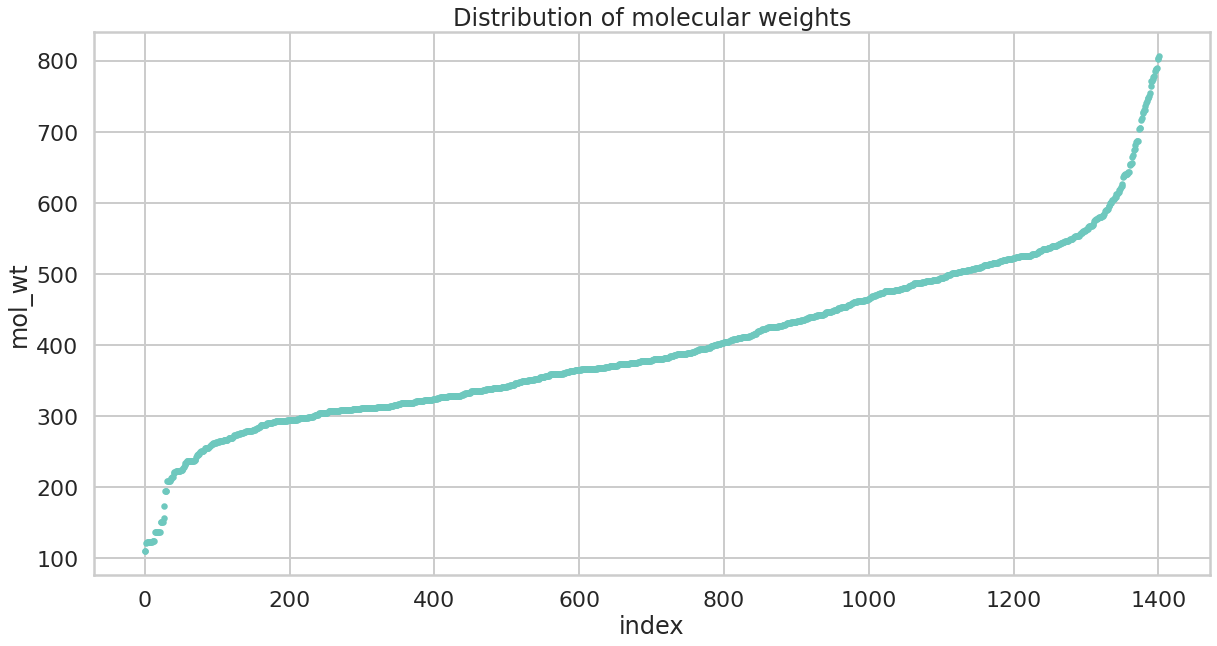

In [46]:
HRH1_cur["mol_wt"] = [Chem.Descriptors.ExactMolWt(Chem.MolFromSmiles(smile)) for smile in HRH1_cur["base_rdkit_smiles"]]
HRH1_cur = HRH1_cur.sort_values('mol_wt')
HRH1_cur = HRH1_cur.reset_index(drop=True)
HRH1_cur = HRH1_cur.reset_index() # plot x axis as index #'s
fig,ax=plt.subplots(figsize=(20,10))
HRH1_cur.plot(kind='scatter', x='index', y='mol_wt', ax=ax);
plt.title("Distribution of molecular weights");

In [47]:
# filter for large MW's
print(HRH1_cur.shape)
HRH1_cur = HRH1_cur[HRH1_cur.mol_wt <1400]
print(HRH1_cur.shape)

(1402, 7)
(1402, 7)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


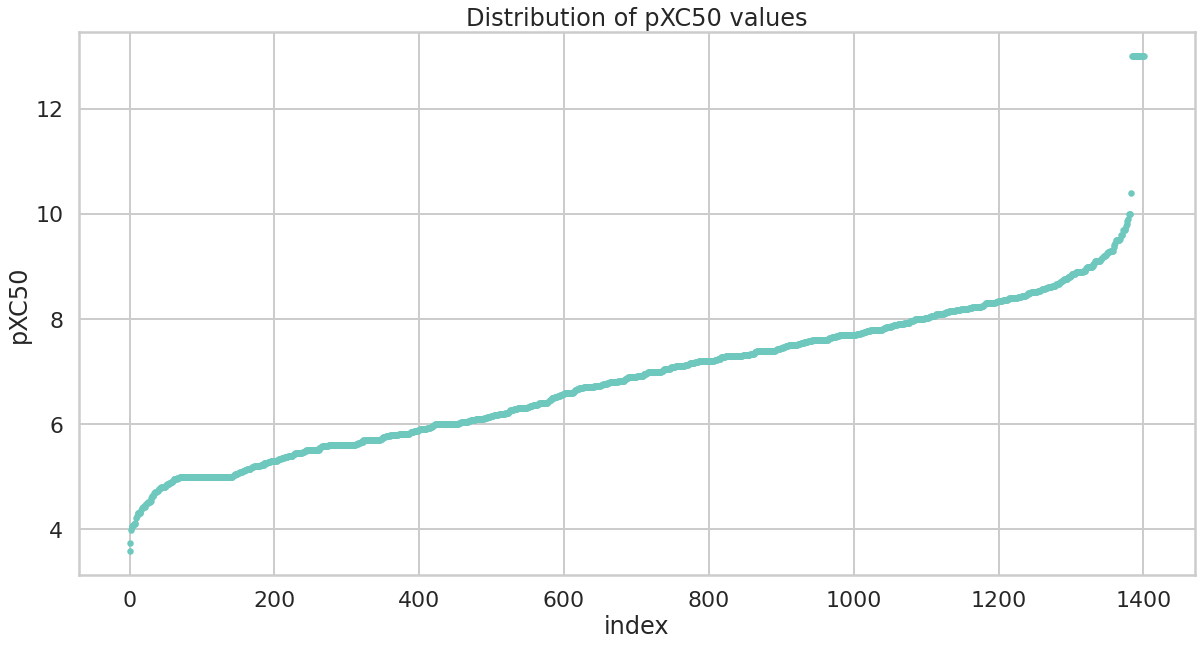

In [48]:
HRH1_cur = HRH1_cur.drop(columns=['index'])
HRH1_cur = HRH1_cur.sort_values('pXC50')
HRH1_cur = HRH1_cur.reset_index(drop=True)
HRH1_cur = HRH1_cur.reset_index() # plot x axis as index #'s
fig,ax=plt.subplots(figsize=(20,10))
HRH1_cur.plot(kind='scatter', x='index', y='pXC50', ax=ax);
plt.title("Distribution of pXC50 values");

In [49]:
# filter for weird pXC50 values
print(HRH1_cur.shape)
HRH1_cur = HRH1_cur[HRH1_cur.pXC50>2]
HRH1_cur = HRH1_cur[HRH1_cur.pXC50<14]
print(HRH1_cur.shape)

(1402, 7)
(1402, 7)


In [50]:
# check for na values
for col in HRH1_cur.columns:
  print(col, HRH1_cur[col].isna().values.any())

index False
compound_id False
base_rdkit_smiles False
relation True
pXC50 False
active False
mol_wt False


In [51]:
HRH1_cur.to_csv("HRH1_cur.csv")

In [52]:
# all these warnings are OK
from atomsci.ddm.pipeline import diversity_plots as dp
from rdkit import Chem
from scipy.stats.kde import gaussian_kde
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoDistMat
import logging

sns.set_context('poster')
ndist_max = 1000000

# Final EDA 
- how many actives & inactives are there?
- what's the dist. of pXC50 values?
- what are the final compound overlaps from the 3 curated datasets?
- what is the distribution of tanimoto distances in the compound sets?
- what is the final diversity plots? MCS? different ECFP radii?

In [53]:
HRH1_cur = pd.read_csv("HRH1_cur.csv", index_col=0)

In [54]:
HRH1_cur.active.sum()

649

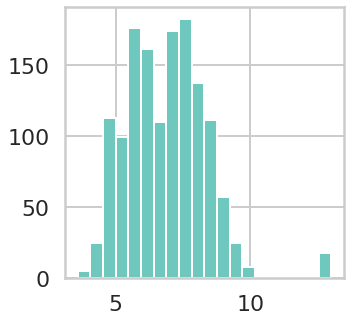

In [55]:
HRH1_cur.pXC50.hist(bins=20, figsize=(5,5));

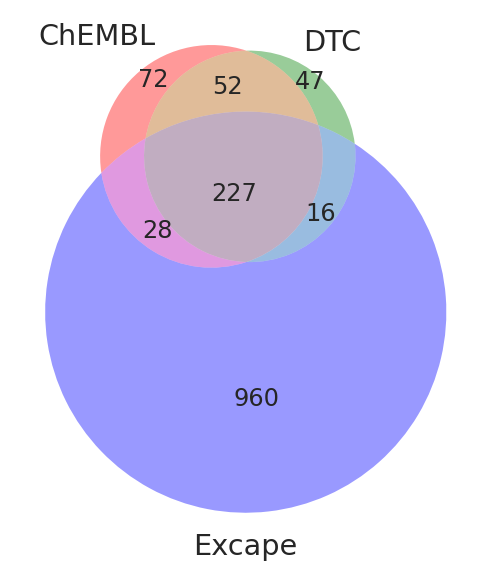

In [56]:
mpv.venn3([set(HRH1.loc[HRH1.datasource=='chembl','base_rdkit_smiles']),
           set(HRH1.loc[HRH1.datasource=='dtc','base_rdkit_smiles']),
           set(HRH1.loc[HRH1.datasource=='excape','base_rdkit_smiles']),],
          set_labels = ['ChEMBL','DTC','Excape']);

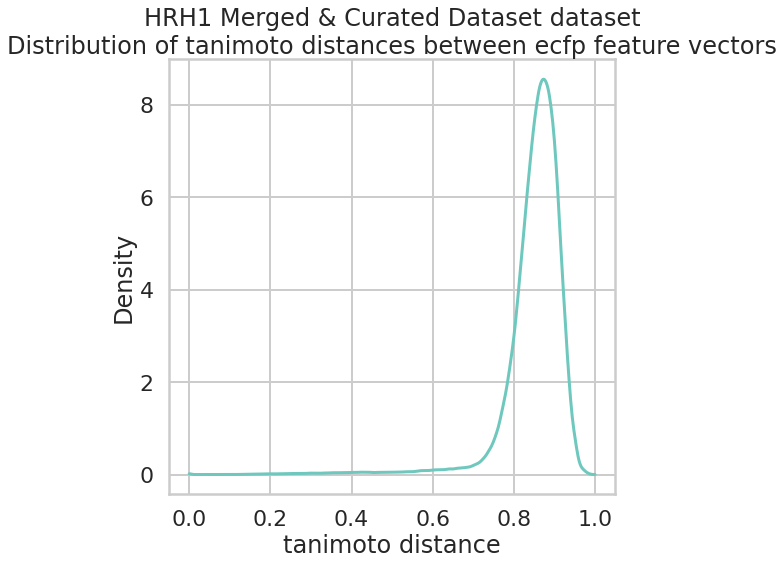

In [57]:
dp.plot_tani_dist_distr(HRH1_cur, 'base_rdkit_smiles', 'HRH1 Merged & Curated Dataset');

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.7/dist-packages/atomsci/ddm/pipeline/diversity_plots.py:303: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  tani_linkage = linkage(tani_dist, method='complete')


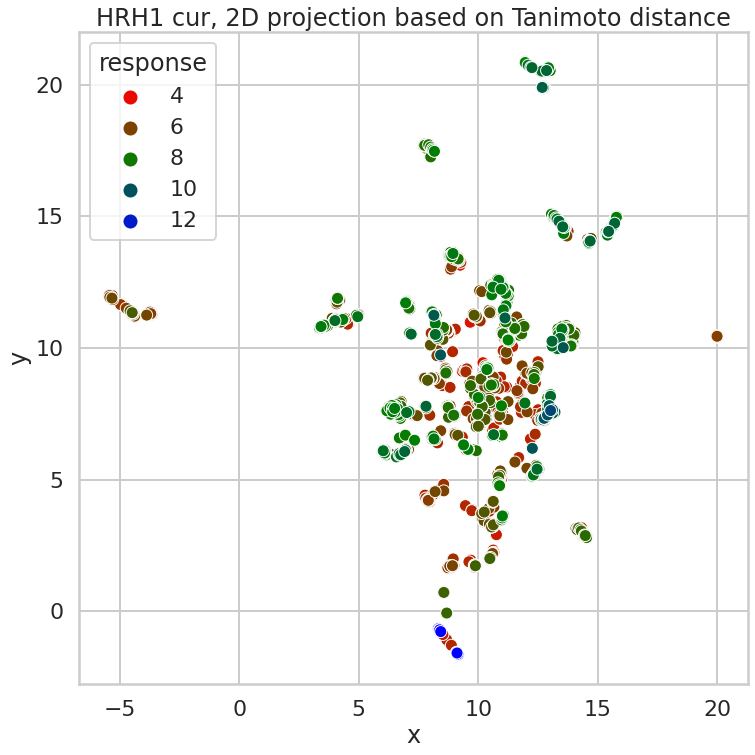

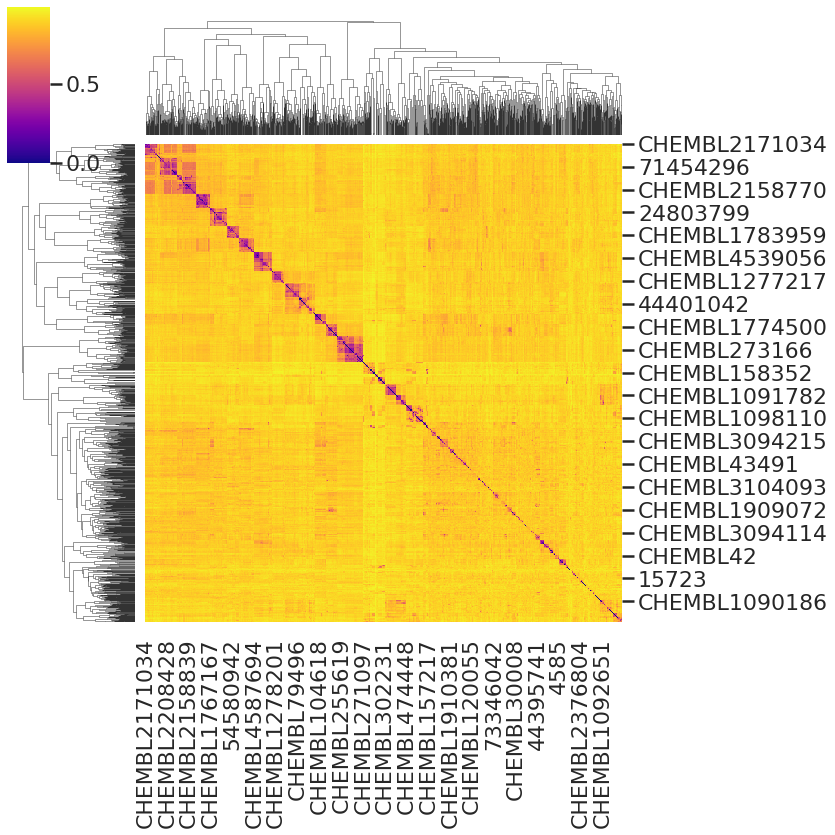

In [58]:
dp.diversity_plots('HRH1_cur.csv', datastore=False,
                   id_col ='compound_id', smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, response_col = 'pXC50')

In [59]:
# dp.diversity_plots('HRH1_cur.csv', datastore=False,
#                    id_col ='compound_id', smiles_col = 'base_rdkit_smiles', 
#                    is_base_smiles=True, response_col = 'pXC50',
#                    ecfp_radius = 2)

In [60]:
# dp.diversity_plots('HRH1_cur.csv', datastore=False,
#                    id_col ='compound_id', smiles_col = 'base_rdkit_smiles', 
#                    is_base_smiles=True, response_col = 'pXC50',
#                    ecfp_radius = 6)

In [61]:
# ***********************************************************************
# warning: takes a long time; use it on system with dedicated resources *
#************************************************************************
# dp.diversity_plots('HRH1_cur.csv', datastore=False,
#                    id_col ='compound_id', smiles_col = 'base_rdkit_smiles', 
#                    is_base_smiles=True, response_col = 'pXC50', 
#                    max_for_mcs=1500)

# Now you're ready to move on to the next stage of EDA & modeling: featurizing datasets
- featurize with structure-based fingerprints like ECFP
- or molecular descriptor sets like RDKit and Mordred
- these are high - dimensional datasets (200-2000 features or 'dimensions')
- so UMAP, tSNE and other dimensionality reduction techniques will help visualize the 'chemical space' of the dataset